In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

### Testing Inpainting Baselines

---

In [13]:
from helpers.dataset import InpaintingDataset
from helpers.data_utils import post_process_image, numpy_to_pil, pil_black_to_white_bg, denormalise_image_torch, pil_to_tensor
from helpers.dataset import get_dataloaders
from helpers.metrics import compute_all_metrics

from diffusers import StableDiffusionInpaintPipeline, AutoPipelineForInpainting, StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel

import torch

import numpy as np
from PIL import Image, ImageOps

from omegaconf import OmegaConf

from tqdm import tqdm

### Data

In [4]:
prompt = "fill the missing parts of a fabric texture matching the existing colors and style, if not sure then fill with red"
negative_prompt = "no black parts"

In [5]:
cfg = OmegaConf.load("../configs/train.yaml")
dataset = InpaintingDataset(cfg)
i = 6611
sample = dataset[i]
diffuse_img, partial_img, mask = sample["full_diffuse_img"], sample["partial_diffuse_img"], sample["mask"]

In [6]:
trn_loader, val_loader = get_dataloaders(cfg)

In [7]:
target_img_pil = numpy_to_pil(post_process_image(diffuse_img))
partial_img_pil = numpy_to_pil(post_process_image(partial_img))
partial_img_pil_inv = pil_black_to_white_bg(partial_img_pil)

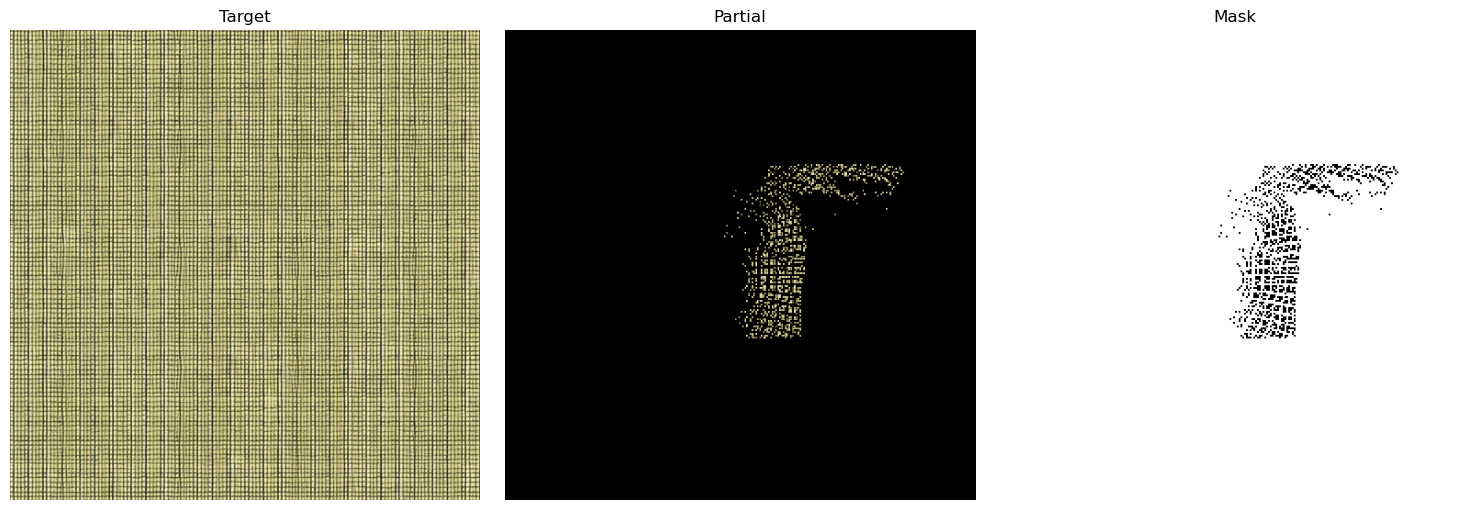

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(target_img_pil)
ax[0].set_title("Target")
ax[0].axis("off")

ax[1].imshow(partial_img_pil)
ax[1].set_title("Partial")
ax[1].axis("off")

ax[2].imshow(mask.transpose(1, 2, 0), cmap="gray")
# ax[2].set_title("Mask (1 = white -> fill , 0 = black -> keep)")
ax[2].set_title("Mask")
ax[2].axis("off")

plt.tight_layout()
plt.show()

#### Text based only

In [16]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
 "runwayml/stable-diffusion-inpainting",   # "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [8]:
result = pipe(prompt=prompt, image=partial_img_pil_inv).images[0]

NameError: name 'partial_img_pil_inv' is not defined

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(partial_img_pil_inv)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask.transpose(1, 2, 0), cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
outputs = []
for batch in tqdm(val_loader):
    prompts = [prompt]*len(batch["partial_diffuse_img"])
    zero_one_img_tensors = denormalise_image_torch(batch["partial_diffuse_img"])
    reconstructed_imgs = pipe(prompts, image=zero_one_img_tensors, mask_image=batch["mask"], guidance_scale=7.5, strength=0.9).images

    reconstructed_imgs_tensors = torch.stack([pil_to_tensor(img) for img in reconstructed_imgs]).to("cpu")
    target_imgs = denormalise_image_torch(batch["full_diffuse_img"])
    image_metrics = compute_all_metrics(reconstructed_imgs_tensors, target_imgs)
    outputs.append(image_metrics)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [15]:

# Compute metrics
all_ssim = torch.cat([output["ssim"] for output in outputs])
all_psnr = torch.cat([output["psnr"] for output in outputs])
all_lpips = torch.cat([output["lpips"] for output in outputs])

mean_ssim = all_ssim.mean()
mean_psnr = all_psnr.mean()
mean_lpips = all_lpips.mean()

print(f"SSIM: {mean_ssim}, PSNR: {mean_psnr}, LPIPS: {mean_lpips}")

SSIM: 0.02430877275764942, PSNR: 6.464392185211182, LPIPS: 0.9525905251502991


#### Text+Image inpainting

In [ ]:
# Load the ControlNet model
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)

# Initialize the pipeline with ControlNet
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
).to("cuda")

In [ ]:
result = pipe(prompt=prompt, image=partial_img_pil, mask_image=mask, control_image=partial_img_pil_inv, strength=0.95).images[0]

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(partial_img_pil_inv)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask.transpose(1, 2, 0), cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()

### Inpainting with task specific SD

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
 "sd-legacy/stable-diffusion-inpainting",   
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
).to("cuda")
pipe.enable_model_cpu_offload()

In [ ]:
result = pipe(prompt=prompt, image=partial_img_pil, mask_image=mask, strength=0.95, guidance_scale=10, num_inference_steps=50).images[0]

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(partial_img_pil)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask.transpose(1, 2, 0), cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()